<center>
    <h1>Time Series Forecasting using LSTM</h1>
    <h3>Name: Sai Sri Meghana Dharmapuri</h3>
</center>

# 1. Reading the dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)
    
# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low


In [2]:
df_stock = pd.read_csv('CSC215_P2_Stock_Price.csv')

In [3]:
df_stock.shape

(4392, 7)

In [4]:
df_stock.head()

,Date,Open,High,Low,Close,Adj_Close,Volume
0,2000/3/27,3.812500,4.156250,3.812500,4.125000,4.125000,3675600
1,2000/3/28,4.125000,4.125000,4.000000,4.015625,4.015625,1077600
2,2000/3/29,4.000000,4.031250,3.953125,4.000000,4.000000,437200
3,2000/3/30,4.000000,4.000000,3.843750,3.843750,3.843750,1883600
4,2000/3/31,3.734375,3.734375,3.390625,3.390625,3.390625,7931600


# Data Cleaning 

# 2. Drop Date and Adj_Close columns

In [5]:
# storing the original dataset in a different dataframe before dropping the columns 
df_stock_new = df_stock
df_stock_new.head()

,Date,Open,High,Low,Close,Adj_Close,Volume
0,2000/3/27,3.812500,4.156250,3.812500,4.125000,4.125000,3675600
1,2000/3/28,4.125000,4.125000,4.000000,4.015625,4.015625,1077600
2,2000/3/29,4.000000,4.031250,3.953125,4.000000,4.000000,437200
3,2000/3/30,4.000000,4.000000,3.843750,3.843750,3.843750,1883600
4,2000/3/31,3.734375,3.734375,3.390625,3.390625,3.390625,7931600


In [6]:
# dropping the columns Date and Adj_Close
df_stock_new=df_stock_new.drop(['Date', 'Adj_Close'], axis=1)
df_stock_new.head()
#df_stock_new.['y'] = df_stock_new.['Close']

,Open,High,Low,Close,Volume
0,3.812500,4.156250,3.812500,4.125000,3675600
1,4.125000,4.125000,4.000000,4.015625,1077600
2,4.000000,4.031250,3.953125,4.000000,437200
3,4.000000,4.000000,3.843750,3.843750,1883600
4,3.734375,3.734375,3.390625,3.390625,7931600


In [7]:
df_stock_new.shape

(4392, 5)

In [8]:
df_stock.shape

(4392, 7)

# 3. Removing null values 

In [9]:
df_stock_new.shape

(4392, 5)

In [10]:
#Calling sum() of the DataFrame returned by isnull() will give a series containing data about count of NaN in each column
df_stock_new.isnull().sum()

Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

In [11]:
# creating a copy of the column, Close
df_stock_new['y'] = df_stock_new['Close']

In [12]:
df_stock_new.head()

,Open,High,Low,Close,Volume,y
0,3.812500,4.156250,3.812500,4.125000,3675600,4.125000
1,4.125000,4.125000,4.000000,4.015625,1077600,4.015625
2,4.000000,4.031250,3.953125,4.000000,437200,4.000000
3,4.000000,4.000000,3.843750,3.843750,1883600,3.843750
4,3.734375,3.734375,3.390625,3.390625,7931600,3.390625


# 4. Normalizing the columns 

In [13]:
#Normalizing the training numeric values using zscore
from scipy.stats import zscore
df_stock_new['Open'] = zscore(df_stock_new['Open'])
df_stock_new['High'] = zscore(df_stock_new['High'])
df_stock_new['Low'] = zscore(df_stock_new['Low'])
df_stock_new['Close'] = zscore(df_stock_new['Close'])
df_stock_new['Volume'] = zscore(df_stock_new['Volume'])

In [14]:
x=df_stock_new.as_matrix(columns=['Open','High','Low','Volume','Close'])

C:\Users\Prerak\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


In [15]:
x.shape

(4392, 5)

In [16]:
df_stock_new.shape

(4392, 6)

In [17]:
#y=df_stock_new.as_matrix(['y'])

In [18]:
y=df_stock_new['y'].tolist()

In [19]:
y=np.array(y)

In [20]:
y.shape

(4392,)

# 4. Data Transformation

In [21]:
import numpy as np

def to_sequences(seq_size, data1, data2):
    x = []
    y = []

    for i in range(len(data1)-seq_size):
        #print(i)
        window = data1[i:(i+seq_size)]
        after_window = data2[i+seq_size]
        window = [[x] for x in window]
        #print("{} - {}".format(window,after_window))
        x.append(window)
        y.append(after_window)
        
    return np.array(x), np.array(y)

In [22]:
SEQUENCE_SIZE = 7
x_seq, y_seq = to_sequences(SEQUENCE_SIZE,x,y)
#x_lstm_seq_test,y_lstm_seq_test = to_sequences(SEQUENCE_SIZE,X_test,y_test)

print("Shape of x_seq: {}".format(x_seq.shape))
#print("Shape of x_test: {}".format(x_lstm_seq_test.shape))
print("Shape of y_seq: {}".format(y_seq.shape))
#print("Shape of y_test: {}".format(y_lstm_seq_test.shape))

Shape of x_seq: (4385, 7, 1, 5)
Shape of y_seq: (4385,)


In [23]:
x_seq_3d = x_seq.reshape(4385,7,5)

# 5. Splitting the dataset into test and train data ( 70% train & 30% test )

In [24]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(x_seq_3d,y_seq,test_size=0.30,random_state=0)

In [25]:
X_train.shape

(3069, 7, 5)

In [26]:
len(X_train)

3069

In [27]:
X_test.shape

(1316, 7, 5)

In [28]:
Y_train.shape

(3069,)

In [29]:
Y_test.shape

(1316,)

In [30]:
type(Y_test)
type(X_test)
type(X_train)
type(Y_train)

numpy.ndarray

# <center> <h1>LSTM</h1></center>

<h4>Approch 1</h4>
<ul>
    <li>LSTM Layers : 64
    <li>Dropout : 0.1, Recurrent Dropout : 0.1
    <li>Dense Layers : 32,32, 1
    <li>Optimizers : adam, sgd
    <li>Activation Functions : relu, sigmoid, tanh
</ul>




Model trained for "adam" optimizer and "relu" activation function : 

Train on 3069 samples, validate on 1316 samples
Epoch 1/200
3069/3069 - 11s - loss: 1006.8796 - val_loss: 252.4246
Epoch 2/200
3069/3069 - 2s - loss: 115.7590 - val_loss: 21.1544
Epoch 3/200
3069/3069 - 2s - loss: 26.5759 - val_loss: 5.6480
Epoch 4/200
3069/3069 - 2s - loss: 21.8157 - val_loss: 6.6411
Epoch 5/200
3069/3069 - 2s - loss: 18.9137 - val_loss: 7.9239
Epoch 6/200
3069/3069 - 2s - loss: 15.7295 - val_loss: 4.0688
Epoch 7/200
3069/3069 - 2s - loss: 15.1983 - val_loss: 6.7518
Epoch 8/200
3069/3069 - 2s - loss: 12.6489 - val_loss: 4.6263
Epoch 9/200
3069/3069 - 2s - loss: 9.7961 - val_loss: 7.0685
Epoch 10/200
3069/3069 - 2s - loss: 8.7211 - val_loss: 7.5107
Epoch 11/200
3069/3069 - 2s - loss: 8.2662 - val_loss: 11.0338
Epoch 00011: early stopping


Final score (MSE): 4.0687969913382
Final score (RMSE): 2.017125923520443


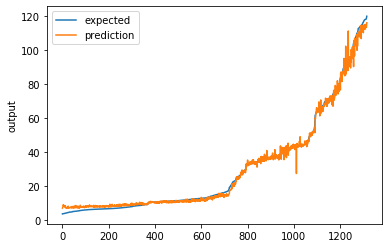




Model trained for "adam" optimizer and "sigmoid" activation function : 

Train on 3069 samples, validate on 1316 samples
Epoch 1/200
3069/3069 - 9s - loss: 1703.6008 - val_loss: 1544.2814
Epoch 2/200
3069/3069 - 2s - loss: 1499.1941 - val_loss: 1407.0775
Epoch 3/200
3069/3069 - 2s - loss: 1386.5535 - val_loss: 1315.0510
Epoch 4/200
3069/3069 - 2s - loss: 1303.9354 - val_loss: 1242.0446
Epoch 5/200
3069/3069 - 2s - loss: 1236.0723 - val_loss: 1180.8955
Epoch 6/200
3069/3069 - 2s - loss: 1178.3179 - val_loss: 1129.7375
Epoch 7/200
3069/3069 - 2s - loss: 1129.2835 - val_loss: 1084.8680
Epoch 8/200
3069/3069 - 2s - loss: 1087.5836 - val_loss: 1047.3690
Epoch 9/200
3069/3069 - 2s - loss: 1052.1624 - val_loss: 1016.4748
Epoch 10/200
3069/3069 - 2s - loss: 1022.5215 - val_loss: 989.8436
Epoch 11/200
3069/3069 - 2s - loss: 997.5426 - val_loss: 968.0170
Epoch 12/200
3069/3069 - 2s - loss: 976.8014 - val_loss: 950.1625
Epoch 13/200
3069/3069 - 2s - loss: 959.7494 - val_loss: 935.5597
Epoch 14

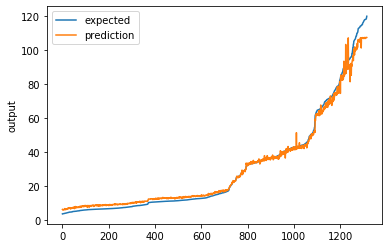




Model trained for "adam" optimizer and "tanh" activation function : 

Train on 3069 samples, validate on 1316 samples
Epoch 1/200
3069/3069 - 5s - loss: 1524.5735 - val_loss: 1305.6229
Epoch 2/200
3069/3069 - 1s - loss: 1264.9551 - val_loss: 1180.6063
Epoch 3/200
3069/3069 - 1s - loss: 1156.8715 - val_loss: 1067.7294
Epoch 4/200
3069/3069 - 1s - loss: 1038.5992 - val_loss: 959.1313
Epoch 5/200
3069/3069 - 2s - loss: 938.5931 - val_loss: 868.2888
Epoch 6/200
3069/3069 - 1s - loss: 851.8365 - val_loss: 787.5791
Epoch 7/200
3069/3069 - 1s - loss: 775.6165 - val_loss: 718.9664
Epoch 8/200
3069/3069 - 1s - loss: 707.7605 - val_loss: 656.3986
Epoch 9/200
3069/3069 - 2s - loss: 651.6007 - val_loss: 602.8453
Epoch 10/200
3069/3069 - 1s - loss: 596.5254 - val_loss: 554.7259
Epoch 11/200
3069/3069 - 2s - loss: 549.7432 - val_loss: 512.2300
Epoch 12/200
3069/3069 - 2s - loss: 509.0656 - val_loss: 475.1665
Epoch 13/200
3069/3069 - 1s - loss: 471.8506 - val_loss: 438.3323
Epoch 14/200
3069/3069 

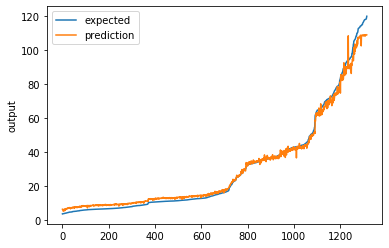




Model trained for "sgd" optimizer and "relu" activation function : 

Train on 3069 samples, validate on 1316 samples
Epoch 1/200
3069/3069 - 9s - loss: nan - val_loss: nan


C:\Users\Prerak\Anaconda3\lib\site-packages\tensorflow_core\python\keras\callbacks.py:1225: RuntimeWarning: invalid value encountered in less
  if self.monitor_op(current - self.min_delta, self.best):
C:\Users\Prerak\Anaconda3\lib\site-packages\tensorflow_core\python\keras\callbacks.py:992: RuntimeWarning: invalid value encountered in less
  if self.monitor_op(current, self.best):


Epoch 2/200
3069/3069 - 2s - loss: nan - val_loss: nan
Epoch 3/200
3069/3069 - 2s - loss: nan - val_loss: nan
Epoch 4/200
3069/3069 - 2s - loss: nan - val_loss: nan
Epoch 5/200
3069/3069 - 2s - loss: nan - val_loss: nan
Epoch 00005: early stopping


Final score (MSE): 1591.2558393372767
Final score (RMSE): 39.890548245634285


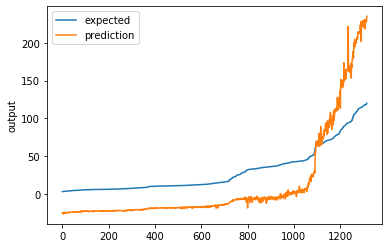




Model trained for "sgd" optimizer and "sigmoid" activation function : 

Train on 3069 samples, validate on 1316 samples
Epoch 1/200
3069/3069 - 8s - loss: 223.2238 - val_loss: 63.6421
Epoch 2/200
3069/3069 - 2s - loss: 41.2196 - val_loss: 12.9056
Epoch 3/200
3069/3069 - 2s - loss: 25.3883 - val_loss: 7.4592
Epoch 4/200
3069/3069 - 2s - loss: 24.1097 - val_loss: 36.4628
Epoch 5/200
3069/3069 - 2s - loss: 12.2619 - val_loss: 5.8253
Epoch 6/200
3069/3069 - 2s - loss: 9.3153 - val_loss: 14.5198
Epoch 7/200
3069/3069 - 2s - loss: 8.4834 - val_loss: 3.5361
Epoch 8/200
3069/3069 - 2s - loss: 9.7031 - val_loss: 7.4421
Epoch 9/200
3069/3069 - 2s - loss: 7.3838 - val_loss: 7.9914
Epoch 10/200
3069/3069 - 2s - loss: 6.1587 - val_loss: 6.3438
Epoch 11/200
3069/3069 - 2s - loss: 4.9957 - val_loss: 4.6596
Epoch 12/200
3069/3069 - 2s - loss: 4.3225 - val_loss: 6.0255
Epoch 00012: early stopping


Final score (MSE): 3.5360892838680655
Final score (RMSE): 1.880449223953698


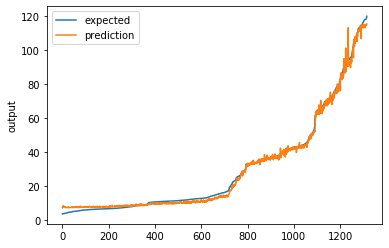




Model trained for "sgd" optimizer and "tanh" activation function : 

Train on 3069 samples, validate on 1316 samples
Epoch 1/200
3069/3069 - 9s - loss: 250.6560 - val_loss: 20.7189
Epoch 2/200
3069/3069 - 2s - loss: 41.6864 - val_loss: 15.1868
Epoch 3/200
3069/3069 - 2s - loss: 26.2816 - val_loss: 10.6799
Epoch 4/200
3069/3069 - 2s - loss: 20.7941 - val_loss: 4.0575
Epoch 5/200
3069/3069 - 2s - loss: 16.1217 - val_loss: 9.2013
Epoch 6/200
3069/3069 - 2s - loss: 13.5078 - val_loss: 7.7276
Epoch 7/200
3069/3069 - 2s - loss: 9.9034 - val_loss: 4.3062
Epoch 8/200
3069/3069 - 2s - loss: 16.0637 - val_loss: 16.0767
Epoch 9/200
3069/3069 - 2s - loss: 7.0941 - val_loss: 6.7969
Epoch 00009: early stopping


Final score (MSE): 4.057501017436194
Final score (RMSE): 2.0143239603986727


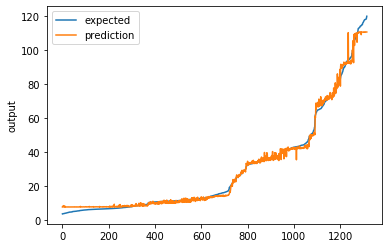

In [31]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn import metrics

optimizers = ['adam','sgd']
activation_functions = ['relu','sigmoid','tanh']

for opt in optimizers:
    for act in activation_functions:

        print("\n\n\nModel trained for \"{}\" optimizer and \"{}\" activation function : \n".format(opt,act))
        model = Sequential()

        model.add(LSTM(64, dropout=0.1, recurrent_dropout=0.1, input_shape=(7,5)))
        model.add(Dense(32, activation=act))
        model.add(Dense(32, activation=act))
        model.add(Dense(1))

        model.compile(loss='mean_squared_error', optimizer=opt)
        monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
        checkpointer = ModelCheckpoint(filepath="best_weights_LSTM.hdf5", verbose=0, save_best_only=True)

        model.fit(X_train,Y_train,validation_data=(X_test,Y_test),callbacks=[monitor, checkpointer],verbose=2, epochs=200)
        
        model.load_weights('best_weights_LSTM.hdf5')

        pred = model.predict(X_test)
        
        # Measure MSE error.  
        mse = metrics.mean_squared_error(pred,Y_test)
        print("\n\nFinal score (MSE): {}".format(mse))
        
        # Measure RMSE error.  RMSE is common for regression.
        rmse = np.sqrt(metrics.mean_squared_error(pred,Y_test))
        print("Final score (RMSE): {}".format(rmse))
        
        chart_regression(pred.flatten(),Y_test,sort=True)

<h4>Approch 2</h4>
<ul>
    <li>LSTM Layers : 64
    <li>Dropout : 0.1, Recurrent Dropout : 0.1
    <li>Dense Layers : 32, 1
    <li>Optimizers : adam, sgd
    <li>Activation Functions : relu, sigmoid, tanh
</ul>




Model trained for "adam" optimizer and "relu" activation function : 

Train on 3069 samples, validate on 1316 samples
Epoch 1/200
3069/3069 - 9s - loss: 1062.1868 - val_loss: 270.4081
Epoch 2/200
3069/3069 - 2s - loss: 119.7021 - val_loss: 29.9218
Epoch 3/200
3069/3069 - 2s - loss: 33.5733 - val_loss: 7.4916
Epoch 4/200
3069/3069 - 2s - loss: 23.8178 - val_loss: 6.2048
Epoch 5/200
3069/3069 - 2s - loss: 20.2524 - val_loss: 5.4324
Epoch 6/200
3069/3069 - 2s - loss: 16.6854 - val_loss: 4.8617
Epoch 7/200
3069/3069 - 2s - loss: 17.2414 - val_loss: 4.0259
Epoch 8/200
3069/3069 - 2s - loss: 11.8430 - val_loss: 5.0725
Epoch 9/200
3069/3069 - 2s - loss: 11.4926 - val_loss: 7.4086
Epoch 10/200
3069/3069 - 2s - loss: 11.0117 - val_loss: 3.9151
Epoch 11/200
3069/3069 - 2s - loss: 11.7351 - val_loss: 4.9420
Epoch 12/200
3069/3069 - 2s - loss: 8.8807 - val_loss: 5.7290
Epoch 13/200
3069/3069 - 2s - loss: 9.4268 - val_loss: 4.7676
Epoch 14/200
3069/3069 - 2s - loss: 9.4176 - val_loss: 5.7032
Epo

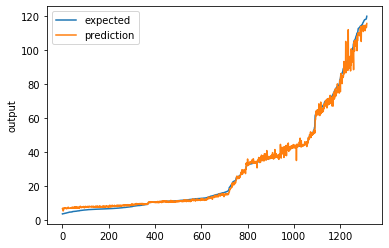




Model trained for "adam" optimizer and "sigmoid" activation function : 

Train on 3069 samples, validate on 1316 samples
Epoch 1/200
3069/3069 - 9s - loss: 963.2585 - val_loss: 205.5297
Epoch 2/200
3069/3069 - 2s - loss: 106.5661 - val_loss: 24.6087
Epoch 3/200
3069/3069 - 2s - loss: 34.5578 - val_loss: 8.6872
Epoch 4/200
3069/3069 - 2s - loss: 23.7116 - val_loss: 5.1863
Epoch 5/200
3069/3069 - 2s - loss: 20.4888 - val_loss: 4.9808
Epoch 6/200
3069/3069 - 2s - loss: 18.8328 - val_loss: 4.3615
Epoch 7/200
3069/3069 - 2s - loss: 15.1350 - val_loss: 5.2929
Epoch 8/200
3069/3069 - 2s - loss: 13.0454 - val_loss: 5.0759
Epoch 9/200
3069/3069 - 2s - loss: 11.9332 - val_loss: 5.6649
Epoch 10/200
3069/3069 - 2s - loss: 10.2859 - val_loss: 13.3794
Epoch 11/200
3069/3069 - 2s - loss: 14.4429 - val_loss: 4.6654
Epoch 00011: early stopping


Final score (MSE): 4.361511622428448
Final score (RMSE): 2.0884232383375854


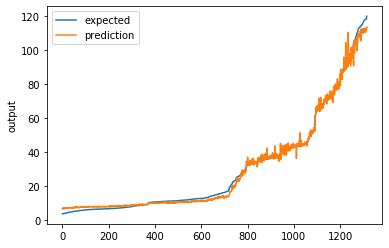




Model trained for "adam" optimizer and "tanh" activation function : 

Train on 3069 samples, validate on 1316 samples
Epoch 1/200
3069/3069 - 8s - loss: 956.8588 - val_loss: 186.1887
Epoch 2/200
3069/3069 - 2s - loss: 98.2037 - val_loss: 22.4602
Epoch 3/200
3069/3069 - 2s - loss: 34.0096 - val_loss: 7.8234
Epoch 4/200
3069/3069 - 2s - loss: 24.5548 - val_loss: 4.6801
Epoch 5/200
3069/3069 - 2s - loss: 20.7156 - val_loss: 5.9519
Epoch 6/200
3069/3069 - 2s - loss: 16.7711 - val_loss: 4.3606
Epoch 7/200
3069/3069 - 2s - loss: 15.9881 - val_loss: 5.0360
Epoch 8/200
3069/3069 - 2s - loss: 14.1545 - val_loss: 4.5381
Epoch 9/200
3069/3069 - 2s - loss: 12.3811 - val_loss: 7.2422
Epoch 10/200
3069/3069 - 2s - loss: 9.5987 - val_loss: 7.1091
Epoch 11/200
3069/3069 - 2s - loss: 10.2715 - val_loss: 6.7930
Epoch 00011: early stopping


Final score (MSE): 4.360648891982585
Final score (RMSE): 2.088216677450543


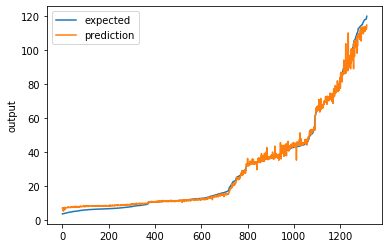




Model trained for "sgd" optimizer and "relu" activation function : 

Train on 3069 samples, validate on 1316 samples
Epoch 1/200
3069/3069 - 8s - loss: nan - val_loss: nan


C:\Users\Prerak\Anaconda3\lib\site-packages\tensorflow_core\python\keras\callbacks.py:1225: RuntimeWarning: invalid value encountered in less
  if self.monitor_op(current - self.min_delta, self.best):
C:\Users\Prerak\Anaconda3\lib\site-packages\tensorflow_core\python\keras\callbacks.py:992: RuntimeWarning: invalid value encountered in less
  if self.monitor_op(current, self.best):


Epoch 2/200
3069/3069 - 2s - loss: nan - val_loss: nan
Epoch 3/200
3069/3069 - 2s - loss: nan - val_loss: nan
Epoch 4/200
3069/3069 - 2s - loss: nan - val_loss: nan
Epoch 5/200
3069/3069 - 2s - loss: nan - val_loss: nan
Epoch 00005: early stopping


Final score (MSE): 4.360648891982585
Final score (RMSE): 2.088216677450543


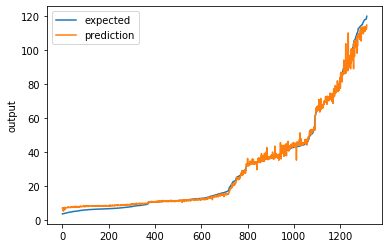




Model trained for "sgd" optimizer and "sigmoid" activation function : 

Train on 3069 samples, validate on 1316 samples
Epoch 1/200
3069/3069 - 7s - loss: nan - val_loss: nan


C:\Users\Prerak\Anaconda3\lib\site-packages\tensorflow_core\python\keras\callbacks.py:1225: RuntimeWarning: invalid value encountered in less
  if self.monitor_op(current - self.min_delta, self.best):
C:\Users\Prerak\Anaconda3\lib\site-packages\tensorflow_core\python\keras\callbacks.py:992: RuntimeWarning: invalid value encountered in less
  if self.monitor_op(current, self.best):


Epoch 2/200
3069/3069 - 2s - loss: nan - val_loss: nan
Epoch 3/200
3069/3069 - 2s - loss: nan - val_loss: nan
Epoch 4/200
3069/3069 - 2s - loss: nan - val_loss: nan
Epoch 5/200
3069/3069 - 2s - loss: nan - val_loss: nan
Epoch 00005: early stopping


Final score (MSE): 4.360648891982585
Final score (RMSE): 2.088216677450543


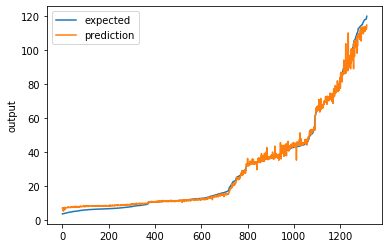




Model trained for "sgd" optimizer and "tanh" activation function : 

Train on 3069 samples, validate on 1316 samples
Epoch 1/200
3069/3069 - 7s - loss: nan - val_loss: nan


C:\Users\Prerak\Anaconda3\lib\site-packages\tensorflow_core\python\keras\callbacks.py:1225: RuntimeWarning: invalid value encountered in less
  if self.monitor_op(current - self.min_delta, self.best):
C:\Users\Prerak\Anaconda3\lib\site-packages\tensorflow_core\python\keras\callbacks.py:992: RuntimeWarning: invalid value encountered in less
  if self.monitor_op(current, self.best):


Epoch 2/200
3069/3069 - 2s - loss: nan - val_loss: nan
Epoch 3/200
3069/3069 - 2s - loss: nan - val_loss: nan
Epoch 4/200
3069/3069 - 2s - loss: nan - val_loss: nan
Epoch 5/200
3069/3069 - 2s - loss: nan - val_loss: nan
Epoch 00005: early stopping


Final score (MSE): 4.360648891982585
Final score (RMSE): 2.088216677450543


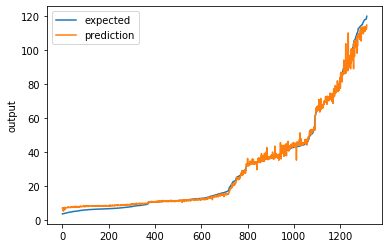

In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn import metrics

optimizers = ['adam','sgd']
activation_functions = ['relu','sigmoid','tanh']

for opt in optimizers:
    for act in activation_functions:

        print("\n\n\nModel trained for \"{}\" optimizer and \"{}\" activation function : \n".format(opt,act))
        model = Sequential()

        model.add(LSTM(64, dropout=0.1, recurrent_dropout=0.1, input_shape=(7,5)))
        model.add(Dense(32))
        model.add(Dense(1))

        model.compile(loss='mean_squared_error', optimizer=opt)
        monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
        checkpointer = ModelCheckpoint(filepath="best_weights_LSTM.hdf5", verbose=0, save_best_only=True)

        model.fit(X_train,Y_train,validation_data=(X_test,Y_test),callbacks=[monitor, checkpointer],verbose=2, epochs=200)
        
        model.load_weights('best_weights_LSTM.hdf5')

        pred = model.predict(X_test)
        
        # Measure MSE error.  
        mse = metrics.mean_squared_error(pred,Y_test)
        print("\n\nFinal score (MSE): {}".format(mse))
        
        # Measure RMSE error.  RMSE is common for regression.
        rmse = np.sqrt(metrics.mean_squared_error(pred,Y_test))
        print("Final score (RMSE): {}".format(rmse))
        
        chart_regression(pred.flatten(),Y_test,sort=True)

<h4>Approch 3</h4>
<ul>
    <li>LSTM Layers : 64, 32
    <li>Dropout : 0.1, Recurrent Dropout : 0.1
    <li>Dense Layers : 32, 1
    <li>Optimizers : adam, sgd
    <li>Activation Functions : relu, sigmoid, tanh
</ul>




Model trained for "adam" optimizer and "relu" activation function : 

Train on 3069 samples, validate on 1316 samples
Epoch 1/200
3069/3069 - 14s - loss: 720.0125 - val_loss: 57.0243
Epoch 2/200
3069/3069 - 3s - loss: 71.4511 - val_loss: 31.8876
Epoch 3/200
3069/3069 - 3s - loss: 46.9291 - val_loss: 13.7346
Epoch 4/200
3069/3069 - 3s - loss: 39.4915 - val_loss: 17.4889
Epoch 5/200
3069/3069 - 3s - loss: 36.6188 - val_loss: 10.1859
Epoch 6/200
3069/3069 - 3s - loss: 32.0903 - val_loss: 7.9693
Epoch 7/200
3069/3069 - 3s - loss: 33.2200 - val_loss: 12.9454
Epoch 8/200
3069/3069 - 3s - loss: 31.8975 - val_loss: 13.7957
Epoch 9/200
3069/3069 - 3s - loss: 27.3509 - val_loss: 7.9952
Epoch 10/200
3069/3069 - 3s - loss: 25.5706 - val_loss: 14.8945
Epoch 11/200
3069/3069 - 3s - loss: 26.8676 - val_loss: 7.9487
Epoch 12/200
3069/3069 - 3s - loss: 20.9209 - val_loss: 9.7921
Epoch 13/200
3069/3069 - 3s - loss: 15.1430 - val_loss: 18.1842
Epoch 14/200
3069/3069 - 3s - loss: 15.7743 - val_loss: 20

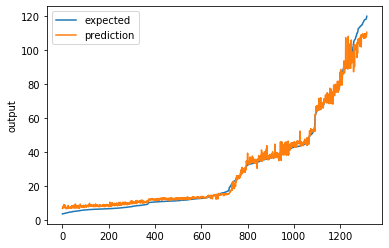




Model trained for "adam" optimizer and "sigmoid" activation function : 

Train on 3069 samples, validate on 1316 samples
Epoch 1/200
3069/3069 - 15s - loss: 1720.4211 - val_loss: 1581.0164
Epoch 2/200
3069/3069 - 3s - loss: 1544.9159 - val_loss: 1452.6495
Epoch 3/200
3069/3069 - 3s - loss: 1426.1835 - val_loss: 1347.1414
Epoch 4/200
3069/3069 - 3s - loss: 1331.4267 - val_loss: 1264.3966
Epoch 5/200
3069/3069 - 3s - loss: 1254.3058 - val_loss: 1195.7709
Epoch 6/200
3069/3069 - 3s - loss: 1189.7134 - val_loss: 1137.5039
Epoch 7/200
3069/3069 - 3s - loss: 1130.2797 - val_loss: 1058.0692
Epoch 8/200
3069/3069 - 3s - loss: 1043.9057 - val_loss: 981.8787
Epoch 9/200
3069/3069 - 3s - loss: 974.0274 - val_loss: 917.4290
Epoch 10/200
3069/3069 - 3s - loss: 911.5095 - val_loss: 858.4135
Epoch 11/200
3069/3069 - 3s - loss: 854.1192 - val_loss: 803.3362
Epoch 12/200
3069/3069 - 3s - loss: 801.3490 - val_loss: 755.1344
Epoch 13/200
3069/3069 - 3s - loss: 752.5317 - val_loss: 710.3642
Epoch 14/20

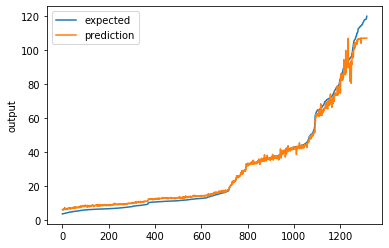




Model trained for "adam" optimizer and "tanh" activation function : 

Train on 3069 samples, validate on 1316 samples
Epoch 1/200
3069/3069 - 15s - loss: 1516.9109 - val_loss: 1279.0201
Epoch 2/200
3069/3069 - 3s - loss: 1238.8458 - val_loss: 1145.8065
Epoch 3/200
3069/3069 - 3s - loss: 1113.0738 - val_loss: 1030.3716
Epoch 4/200
3069/3069 - 3s - loss: 1006.3842 - val_loss: 931.3946
Epoch 5/200
3069/3069 - 3s - loss: 914.1251 - val_loss: 846.1663
Epoch 6/200
3069/3069 - 3s - loss: 831.8871 - val_loss: 770.0092
Epoch 7/200
3069/3069 - 3s - loss: 758.8459 - val_loss: 703.2139
Epoch 8/200
3069/3069 - 3s - loss: 694.1092 - val_loss: 644.1241
Epoch 9/200
3069/3069 - 3s - loss: 636.8419 - val_loss: 590.6358
Epoch 10/200
3069/3069 - 3s - loss: 586.2366 - val_loss: 545.0666
Epoch 11/200
3069/3069 - 3s - loss: 541.2219 - val_loss: 502.5744
Epoch 12/200
3069/3069 - 3s - loss: 500.6467 - val_loss: 466.5824
Epoch 13/200
3069/3069 - 3s - loss: 464.9645 - val_loss: 433.6700
Epoch 14/200
3069/3069

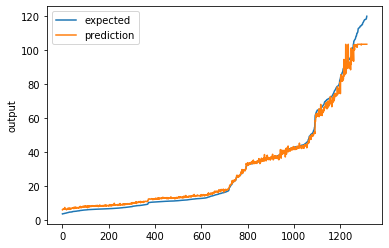




Model trained for "sgd" optimizer and "relu" activation function : 

Train on 3069 samples, validate on 1316 samples
Epoch 1/200
3069/3069 - 16s - loss: nan - val_loss: nan


C:\Users\Prerak\Anaconda3\lib\site-packages\tensorflow_core\python\keras\callbacks.py:1225: RuntimeWarning: invalid value encountered in less
  if self.monitor_op(current - self.min_delta, self.best):
C:\Users\Prerak\Anaconda3\lib\site-packages\tensorflow_core\python\keras\callbacks.py:992: RuntimeWarning: invalid value encountered in less
  if self.monitor_op(current, self.best):


Epoch 2/200
3069/3069 - 4s - loss: nan - val_loss: nan
Epoch 3/200
3069/3069 - 3s - loss: nan - val_loss: nan
Epoch 4/200
3069/3069 - 3s - loss: nan - val_loss: nan
Epoch 5/200
3069/3069 - 3s - loss: nan - val_loss: nan
Epoch 00005: early stopping


Final score (MSE): 2542.254633877826
Final score (RMSE): 50.42077581590575


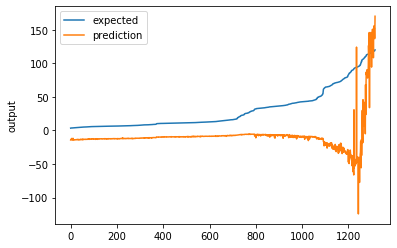




Model trained for "sgd" optimizer and "sigmoid" activation function : 

Train on 3069 samples, validate on 1316 samples
Epoch 1/200
3069/3069 - 15s - loss: 234.1974 - val_loss: 23.9937
Epoch 2/200
3069/3069 - 3s - loss: 40.3040 - val_loss: 31.8222
Epoch 3/200
3069/3069 - 3s - loss: 29.9761 - val_loss: 6.7240
Epoch 4/200
3069/3069 - 3s - loss: 20.1392 - val_loss: 17.5776
Epoch 5/200
3069/3069 - 3s - loss: 14.6481 - val_loss: 12.7704
Epoch 6/200
3069/3069 - 3s - loss: 13.4552 - val_loss: 10.0887
Epoch 7/200
3069/3069 - 3s - loss: 9.4812 - val_loss: 4.9154
Epoch 8/200
3069/3069 - 3s - loss: 8.4717 - val_loss: 24.8581
Epoch 9/200
3069/3069 - 3s - loss: 7.2094 - val_loss: 10.7759
Epoch 10/200
3069/3069 - 3s - loss: 7.5489 - val_loss: 5.0583
Epoch 11/200
3069/3069 - 3s - loss: 5.7434 - val_loss: 5.5997
Epoch 12/200
3069/3069 - 3s - loss: 4.7764 - val_loss: 7.2317
Epoch 00012: early stopping


Final score (MSE): 4.915438785474809
Final score (RMSE): 2.2170788857130925


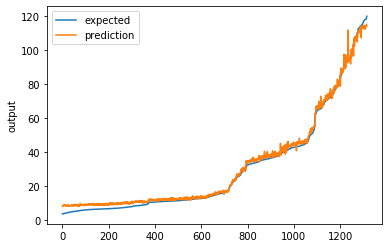




Model trained for "sgd" optimizer and "tanh" activation function : 

Train on 3069 samples, validate on 1316 samples
Epoch 1/200
3069/3069 - 15s - loss: 330.0395 - val_loss: 115.8563
Epoch 2/200
3069/3069 - 3s - loss: 48.0509 - val_loss: 26.7039
Epoch 3/200
3069/3069 - 3s - loss: 30.8028 - val_loss: 12.1121
Epoch 4/200
3069/3069 - 3s - loss: 28.1980 - val_loss: 21.2926
Epoch 5/200
3069/3069 - 3s - loss: 28.6969 - val_loss: 11.3997
Epoch 6/200
3069/3069 - 3s - loss: 17.4103 - val_loss: 21.8184
Epoch 7/200
3069/3069 - 3s - loss: 14.6897 - val_loss: 8.3199
Epoch 8/200
3069/3069 - 3s - loss: 11.2065 - val_loss: 7.0840
Epoch 9/200
3069/3069 - 3s - loss: 10.4290 - val_loss: 13.4152
Epoch 10/200
3069/3069 - 3s - loss: 7.0758 - val_loss: 9.0586
Epoch 11/200
3069/3069 - 3s - loss: 6.9084 - val_loss: 14.1322
Epoch 12/200
3069/3069 - 3s - loss: 6.9296 - val_loss: 11.7016
Epoch 13/200
3069/3069 - 3s - loss: 6.1467 - val_loss: 5.6291
Epoch 14/200
3069/3069 - 3s - loss: 6.2868 - val_loss: 8.5631


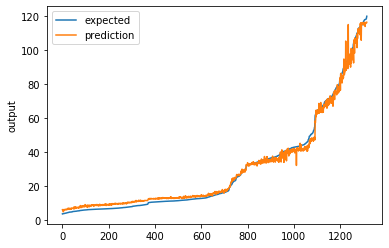

In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn import metrics

optimizers = ['adam','sgd']
activation_functions = ['relu','sigmoid','tanh']

for opt in optimizers:
    for act in activation_functions:

        print("\n\n\nModel trained for \"{}\" optimizer and \"{}\" activation function : \n".format(opt,act))
        model = Sequential()

        model.add(LSTM(64, dropout=0.1, recurrent_dropout=0.1, return_sequences=True, input_shape=(7,5)))
        model.add(LSTM(32, activation=act, dropout=0.1, recurrent_dropout=0.1, input_shape=(7,5)))
        model.add(Dense(32, activation=act))
        model.add(Dense(1))

        model.compile(loss='mean_squared_error', optimizer=opt)
        monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
        checkpointer = ModelCheckpoint(filepath="best_weights_LSTM.hdf5", verbose=0, save_best_only=True)

        model.fit(X_train,Y_train,validation_data=(X_test,Y_test),callbacks=[monitor, checkpointer],verbose=2, epochs=200)
        
        model.load_weights('best_weights_LSTM.hdf5')

        pred = model.predict(X_test)
        
        # Measure MSE error.  
        mse = metrics.mean_squared_error(pred,Y_test)
        print("\n\nFinal score (MSE): {}".format(mse))
        
        # Measure RMSE error.  RMSE is common for regression.
        rmse = np.sqrt(metrics.mean_squared_error(pred,Y_test))
        print("Final score (RMSE): {}".format(rmse))
        
        chart_regression(pred.flatten(),Y_test,sort=True)

<h4>Approch 4</h4>
<ul>
    <li>LSTM Layers : 64, 32
    <li>Dropout : NONE, Recurrent Dropout : NONE
    <li>Dense Layers : 32, 1
    <li>Optimizers : adam, sgd
    <li>Activation Functions : relu, sigmoid, tanh
</ul>




Model trained for "adam" optimizer and "relu" activation function : 

Train on 3069 samples, validate on 1316 samples
Epoch 1/200
3069/3069 - 17s - loss: 619.3962 - val_loss: 49.8878
Epoch 2/200
3069/3069 - 3s - loss: 36.0147 - val_loss: 22.2083
Epoch 3/200
3069/3069 - 3s - loss: 14.6854 - val_loss: 7.1471
Epoch 4/200
3069/3069 - 3s - loss: 6.6435 - val_loss: 9.5388
Epoch 5/200
3069/3069 - 3s - loss: 4.2762 - val_loss: 5.0006
Epoch 6/200
3069/3069 - 3s - loss: 4.6539 - val_loss: 4.2446
Epoch 7/200
3069/3069 - 3s - loss: 3.6312 - val_loss: 4.1281
Epoch 8/200
3069/3069 - 3s - loss: 3.7288 - val_loss: 4.6503
Epoch 9/200
3069/3069 - 3s - loss: 4.3216 - val_loss: 4.6578
Epoch 10/200
3069/3069 - 3s - loss: 4.3018 - val_loss: 6.2074
Epoch 11/200
3069/3069 - 3s - loss: 4.5701 - val_loss: 8.0078
Epoch 12/200
3069/3069 - 3s - loss: 3.7400 - val_loss: 3.9495
Epoch 13/200
3069/3069 - 3s - loss: 3.5264 - val_loss: 5.2911
Epoch 14/200
3069/3069 - 3s - loss: 3.8828 - val_loss: 5.6202
Epoch 15/200


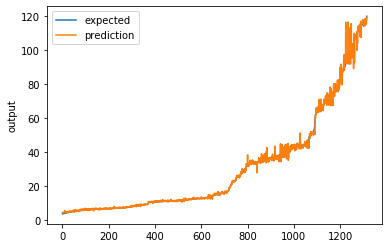




Model trained for "adam" optimizer and "sigmoid" activation function : 

Train on 3069 samples, validate on 1316 samples
Epoch 1/200
3069/3069 - 16s - loss: 1784.0783 - val_loss: 1638.5271
Epoch 2/200
3069/3069 - 3s - loss: 1621.1480 - val_loss: 1545.2408
Epoch 3/200
3069/3069 - 3s - loss: 1534.2914 - val_loss: 1467.0502
Epoch 4/200
3069/3069 - 3s - loss: 1463.0051 - val_loss: 1402.5251
Epoch 5/200
3069/3069 - 3s - loss: 1401.8389 - val_loss: 1345.9893
Epoch 6/200
3069/3069 - 3s - loss: 1347.1645 - val_loss: 1295.1092
Epoch 7/200
3069/3069 - 3s - loss: 1295.9309 - val_loss: 1242.4266
Epoch 8/200
3069/3069 - 3s - loss: 1241.9048 - val_loss: 1191.4970
Epoch 9/200
3069/3069 - 3s - loss: 1188.3894 - val_loss: 1139.3038
Epoch 10/200
3069/3069 - 3s - loss: 1137.3502 - val_loss: 1091.4217
Epoch 11/200
3069/3069 - 3s - loss: 1094.0108 - val_loss: 1054.0826
Epoch 12/200
3069/3069 - 3s - loss: 1023.7112 - val_loss: 964.9920
Epoch 13/200
3069/3069 - 3s - loss: 959.7552 - val_loss: 906.0261
Epo

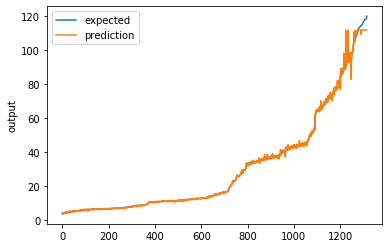




Model trained for "adam" optimizer and "tanh" activation function : 

Train on 3069 samples, validate on 1316 samples
Epoch 1/200
3069/3069 - 18s - loss: 1520.3170 - val_loss: 1303.6508
Epoch 2/200
3069/3069 - 3s - loss: 1264.2591 - val_loss: 1179.6288
Epoch 3/200
3069/3069 - 3s - loss: 1139.5997 - val_loss: 1053.4737
Epoch 4/200
3069/3069 - 3s - loss: 1027.3141 - val_loss: 952.9995
Epoch 5/200
3069/3069 - 3s - loss: 932.3179 - val_loss: 865.7997
Epoch 6/200
3069/3069 - 3s - loss: 848.5873 - val_loss: 788.1218
Epoch 7/200
3069/3069 - 3s - loss: 774.5652 - val_loss: 719.0907
Epoch 8/200
3069/3069 - 3s - loss: 708.7303 - val_loss: 658.8651
Epoch 9/200
3069/3069 - 4s - loss: 650.5127 - val_loss: 604.1646
Epoch 10/200
3069/3069 - 3s - loss: 598.7848 - val_loss: 556.0809
Epoch 11/200
3069/3069 - 3s - loss: 553.0735 - val_loss: 512.7522
Epoch 12/200
3069/3069 - 3s - loss: 511.6760 - val_loss: 475.0280
Epoch 13/200
3069/3069 - 3s - loss: 474.2476 - val_loss: 439.7543
Epoch 14/200
3069/3069

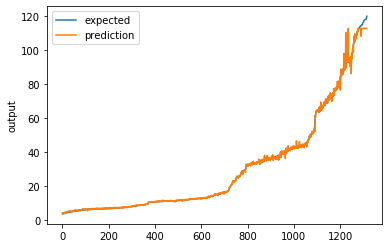




Model trained for "sgd" optimizer and "relu" activation function : 

Train on 3069 samples, validate on 1316 samples
Epoch 1/200
3069/3069 - 17s - loss: nan - val_loss: nan


C:\Users\Prerak\Anaconda3\lib\site-packages\tensorflow_core\python\keras\callbacks.py:1225: RuntimeWarning: invalid value encountered in less
  if self.monitor_op(current - self.min_delta, self.best):
C:\Users\Prerak\Anaconda3\lib\site-packages\tensorflow_core\python\keras\callbacks.py:992: RuntimeWarning: invalid value encountered in less
  if self.monitor_op(current, self.best):


Epoch 2/200
3069/3069 - 3s - loss: nan - val_loss: nan
Epoch 3/200
3069/3069 - 3s - loss: nan - val_loss: nan
Epoch 4/200
3069/3069 - 3s - loss: nan - val_loss: nan
Epoch 5/200
3069/3069 - 3s - loss: nan - val_loss: nan
Epoch 00005: early stopping


Final score (MSE): 630.8682838199628
Final score (RMSE): 25.117091468160936


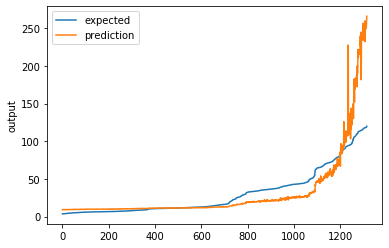




Model trained for "sgd" optimizer and "sigmoid" activation function : 

Train on 3069 samples, validate on 1316 samples
Epoch 1/200
3069/3069 - 15s - loss: 235.9523 - val_loss: 77.0424
Epoch 2/200
3069/3069 - 3s - loss: 22.6975 - val_loss: 21.4063
Epoch 3/200
3069/3069 - 3s - loss: 4.6269 - val_loss: 2.6446
Epoch 4/200
3069/3069 - 3s - loss: 5.3411 - val_loss: 3.0817
Epoch 5/200
3069/3069 - 3s - loss: 3.1146 - val_loss: 3.0474
Epoch 6/200
3069/3069 - 3s - loss: 2.1064 - val_loss: 13.7264
Epoch 7/200
3069/3069 - 3s - loss: 2.2301 - val_loss: 1.3670
Epoch 8/200
3069/3069 - 3s - loss: 1.9487 - val_loss: 1.6641
Epoch 9/200
3069/3069 - 3s - loss: 1.5239 - val_loss: 1.4153
Epoch 10/200
3069/3069 - 3s - loss: 1.2179 - val_loss: 1.6778
Epoch 11/200
3069/3069 - 3s - loss: 1.3266 - val_loss: 1.6066
Epoch 12/200
3069/3069 - 3s - loss: 1.2588 - val_loss: 1.4259
Epoch 00012: early stopping


Final score (MSE): 1.3669578047464828
Final score (RMSE): 1.169169707419108


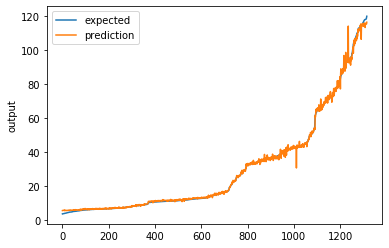




Model trained for "sgd" optimizer and "tanh" activation function : 

Train on 3069 samples, validate on 1316 samples
Epoch 1/200
3069/3069 - 18s - loss: 249.5242 - val_loss: 29.9768
Epoch 2/200
3069/3069 - 3s - loss: 17.8553 - val_loss: 4.4612
Epoch 3/200
3069/3069 - 3s - loss: 5.9355 - val_loss: 3.8754
Epoch 4/200
3069/3069 - 3s - loss: 5.1845 - val_loss: 3.5891
Epoch 5/200
3069/3069 - 3s - loss: 2.8764 - val_loss: 21.2966
Epoch 6/200
3069/3069 - 3s - loss: 3.2014 - val_loss: 4.1632
Epoch 7/200
3069/3069 - 3s - loss: 2.8487 - val_loss: 7.3012
Epoch 8/200
3069/3069 - 3s - loss: 2.0394 - val_loss: 2.1961
Epoch 9/200
3069/3069 - 3s - loss: 2.1949 - val_loss: 2.6040
Epoch 10/200
3069/3069 - 3s - loss: 1.9007 - val_loss: 1.6778
Epoch 11/200
3069/3069 - 3s - loss: 1.7082 - val_loss: 1.7405
Epoch 12/200
3069/3069 - 3s - loss: 1.8358 - val_loss: 2.0331
Epoch 13/200
3069/3069 - 3s - loss: 1.7259 - val_loss: 1.5409
Epoch 14/200
3069/3069 - 3s - loss: 1.5926 - val_loss: 2.9930
Epoch 15/200
30

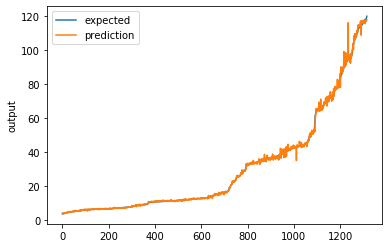

In [34]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn import metrics

optimizers = ['adam','sgd']
activation_functions = ['relu','sigmoid','tanh']

for opt in optimizers:
    for act in activation_functions:

        print("\n\n\nModel trained for \"{}\" optimizer and \"{}\" activation function : \n".format(opt,act))
        model = Sequential()

        model.add(LSTM(64, return_sequences=True, input_shape=(7,5)))
        model.add(LSTM(32, activation=act, input_shape=(7,5)))
        model.add(Dense(32, activation=act))
        model.add(Dense(1))

        model.compile(loss='mean_squared_error', optimizer=opt)
        monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
        checkpointer = ModelCheckpoint(filepath="best_weights_LSTM.hdf5", verbose=0, save_best_only=True)

        model.fit(X_train,Y_train,validation_data=(X_test,Y_test),callbacks=[monitor, checkpointer],verbose=2, epochs=200)
        
        model.load_weights('best_weights_LSTM.hdf5')

        pred = model.predict(X_test)
        
        # Measure MSE error.  
        mse = metrics.mean_squared_error(pred,Y_test)
        print("\n\nFinal score (MSE): {}".format(mse))
        
        # Measure RMSE error.  RMSE is common for regression.
        rmse = np.sqrt(metrics.mean_squared_error(pred,Y_test))
        print("Final score (RMSE): {}".format(rmse))
        
        chart_regression(pred.flatten(),Y_test,sort=True)